In [1]:
import os
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler,random_split
from torchvision import datasets, transforms

In [2]:
DATA_DIR = "/kaggle/input/covid19-radiography-dataset/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset"
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


In [3]:
tfms_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])   
])
tfms_val = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [4]:
full_dataset = datasets.ImageFolder(DATA_DIR,transform=tfms_train)

In [5]:
g = torch.Generator().manual_seed(42)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_ds, val_ds = random_split(full_dataset, [train_size, val_size], generator=g)

In [6]:
#train_ds.dataset.transform=tfms_train
val_ds.dataset.transform=tfms_val

In [7]:
print(f"Train samples: {len(train_ds)}, Validation samples: {len(val_ds)}")

Train samples: 16932, Validation samples: 4233


In [8]:
train_labels = [full_dataset.samples[i][1] for i in train_ds.indices]
class_count = Counter(train_labels)
print("Class counts in train set:", class_count)
print(train_labels[:20])

Class counts in train set: Counter({2: 8153, 1: 4808, 0: 2878, 3: 1093})
[2, 1, 2, 1, 0, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 3, 2, 0]


In [9]:
sample_weights = [1.0 / class_count[label] for label in train_labels]
sample_weights = torch.DoubleTensor(sample_weights)

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),  # draw full train size per epoch
    replacement=True
)

In [10]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          sampler=sampler, num_workers=4, pin_memory=True,persistent_workers=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4, pin_memory=True,persistent_workers=True)

In [11]:
num_classes = len(full_dataset.classes)

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # input: 3x224x224
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 32x112x112
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 64x56x56
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 128x28x28
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self,x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [13]:
model = SimpleCNN(num_classes).to(DEVICE)
print(model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=4, bias=True)
  )
)


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [15]:
def train_one_epoch(epoch):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)


    train_loss=running_loss/total
    train_acc=100*correct/total
    print(f"Epoch {epoch}: Train Loss {train_loss:.4f} "
          f"Acc {train_acc:.2f}%")
    return train_loss, train_acc

In [16]:
def validate():
    model.eval()
    current_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            current_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    val_loss=current_loss/total
    val_acc=100*correct/total
    print(f"Validation: Loss {val_loss:.4f} Acc {val_acc:.2f}%")
    return val_loss, val_acc

In [17]:
train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

In [18]:
import csv
csv_file = open("training_log.csv", mode="w", newline="")
csv_writer = csv.writer(csv_file)
csv_writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc"])

45

In [19]:
for epoch in range(1, EPOCHS + 1):
    train_loss,train_acc=train_one_epoch(epoch)
    val_loss,val_acc=validate()
    
    csv_writer.writerow([epoch, train_loss, train_acc, val_loss, val_acc])
    csv_file.flush()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
csv_file.close()

Epoch 1: Train Loss 0.6830 Acc 72.15%
Validation: Loss 0.5224 Acc 79.31%
Epoch 2: Train Loss 0.3746 Acc 85.84%
Validation: Loss 0.5910 Acc 77.01%
Epoch 3: Train Loss 0.2777 Acc 89.44%
Validation: Loss 0.3505 Acc 86.53%
Epoch 4: Train Loss 0.2127 Acc 91.96%
Validation: Loss 0.3506 Acc 87.48%
Epoch 5: Train Loss 0.1706 Acc 93.66%
Validation: Loss 0.3335 Acc 88.31%
Epoch 6: Train Loss 0.1514 Acc 94.32%
Validation: Loss 0.3614 Acc 87.88%
Epoch 7: Train Loss 0.1336 Acc 95.12%
Validation: Loss 0.3491 Acc 88.38%
Epoch 8: Train Loss 0.1142 Acc 95.72%
Validation: Loss 0.3905 Acc 88.99%
Epoch 9: Train Loss 0.0995 Acc 96.30%
Validation: Loss 0.4499 Acc 88.14%
Epoch 10: Train Loss 0.0908 Acc 96.68%
Validation: Loss 0.4696 Acc 88.05%


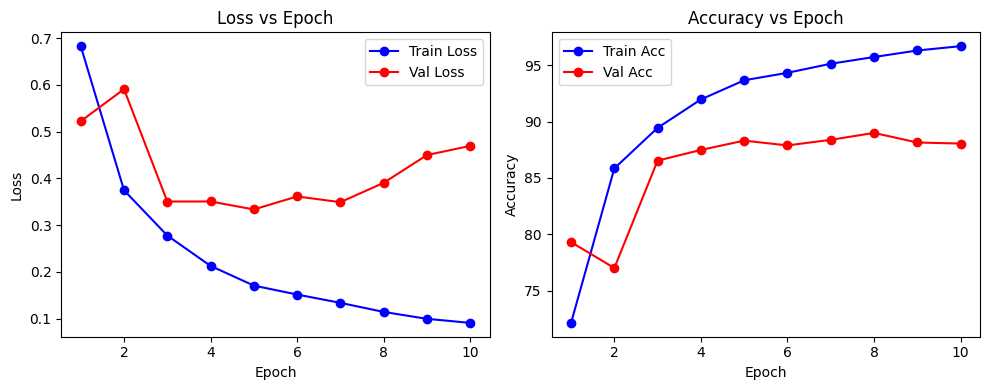

In [22]:
import matplotlib.pyplot as plt
epochs = range(1, EPOCHS+1)
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, val_losses,   'ro-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accs, 'bo-', label='Train Acc')
plt.plot(epochs, val_accs,   'ro-', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()

plt.tight_layout()
plt.savefig("training_curves.png", dpi=300)
plt.show()

In [23]:
torch.save(model, "covid_cnn_model.pt")

TRANSFER LEARNING

In [67]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

In [68]:
tfms_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)   
])
tfms_val = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

In [69]:
dataset = datasets.ImageFolder(DATA_DIR,transform=tfms_train)

In [70]:
g = torch.Generator().manual_seed(42)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_ds, val_ds = random_split(full_dataset, [train_size, val_size], generator=g)

In [71]:
val_ds.dataset.transform=tfms_val

In [72]:
print("Total samples:", len(full_dataset))
print("Train samples:", len(train_ds), "Val samples:", len(val_ds))
print("Classes:", full_dataset.classes)

Total samples: 21165
Train samples: 16932 Val samples: 4233
Classes: ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


In [73]:
train_labels = [full_dataset.samples[i][1] for i in train_ds.indices]
class_count = Counter(train_labels)
print("Class counts in train set:", class_count)
print(train_labels[:20])

Class counts in train set: Counter({2: 8153, 1: 4808, 0: 2878, 3: 1093})
[2, 1, 2, 1, 0, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 3, 2, 0]


In [74]:
sample_weights = [1.0 / class_count[label] for label in train_labels]
sample_weights = torch.DoubleTensor(sample_weights)

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),  # draw full train size per epoch
    replacement=True
)

In [75]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          sampler=sampler, num_workers=4, pin_memory=True,persistent_workers=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4, pin_memory=True,persistent_workers=True)

In [76]:
num_classes = len(full_dataset.classes)

In [77]:
from torchvision import models
weights = models.ResNet18_Weights.IMAGENET1K_V1 
model = models.resnet18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# --- Option A: Feature extraction ---
for name, param in model.named_parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True
    

model = model.to(DEVICE)

for name, p in model.named_parameters():
    if p.requires_grad:
        print(" ", name)

  fc.weight
  fc.bias


In [78]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=LR)

In [86]:
train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

In [87]:
def train_one_epoch(epoch):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)


    train_loss=running_loss/total
    train_acc=100*correct/total
    print(f"Epoch {epoch}: Train Loss {train_loss:.4f} "
          f"Acc {train_acc:.2f}%")
    return train_loss, train_acc

In [88]:
def validate():
    model.eval()
    current_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            current_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    val_loss=current_loss/total
    val_acc=100*correct/total
    print(f"Validation: Loss {val_loss:.4f} Acc {val_acc:.2f}%")
    return val_loss, val_acc

In [82]:
for epoch in range(1, EPOCHS + 1):
    train_loss,train_acc=train_one_epoch(epoch)
    val_loss,val_acc=validate()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

Epoch 1: Train Loss 0.6269 Acc 76.06%
Validation: Loss 0.5313 Acc 79.94%
Epoch 2: Train Loss 0.4528 Acc 82.96%
Validation: Loss 0.4744 Acc 82.05%
Epoch 3: Train Loss 0.4236 Acc 83.89%
Validation: Loss 0.5250 Acc 79.73%
Epoch 4: Train Loss 0.4101 Acc 84.59%
Validation: Loss 0.5255 Acc 79.75%
Epoch 5: Train Loss 0.3975 Acc 84.95%
Validation: Loss 0.5389 Acc 79.00%
Epoch 6: Train Loss 0.3856 Acc 85.48%
Validation: Loss 0.4727 Acc 81.97%
Epoch 7: Train Loss 0.3857 Acc 84.99%
Validation: Loss 0.4656 Acc 81.74%
Epoch 8: Train Loss 0.3733 Acc 85.96%
Validation: Loss 0.4694 Acc 81.64%
Epoch 9: Train Loss 0.3837 Acc 85.33%
Validation: Loss 0.5088 Acc 80.37%
Epoch 10: Train Loss 0.3556 Acc 86.33%
Validation: Loss 0.4499 Acc 82.68%


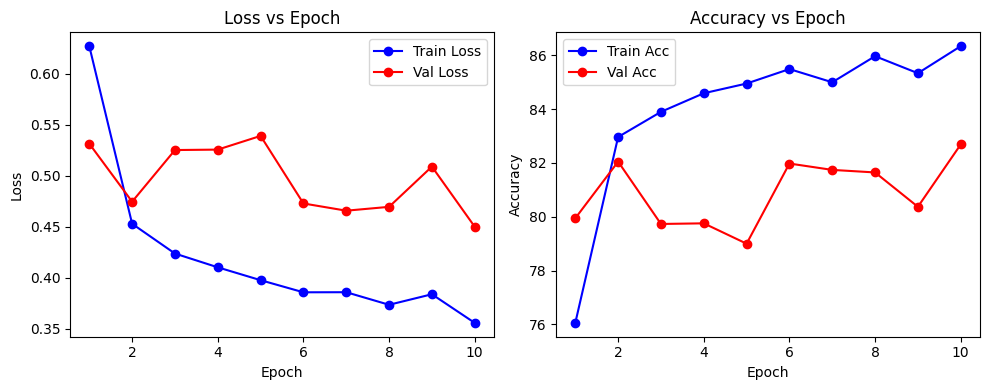

In [83]:
epochs = range(1, EPOCHS+1)
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, val_losses,   'ro-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accs, 'bo-', label='Train Acc')
plt.plot(epochs, val_accs,   'ro-', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()

plt.tight_layout()
plt.savefig("training_curves.png", dpi=300)
plt.show()

FINE TUNING

In [84]:
weights = models.ResNet18_Weights.IMAGENET1K_V1 
model = models.resnet18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, num_classes)


for name, param in model.named_parameters():
    if name.startswith(('layer3','layer4','fc')):
        param.requires_grad = True
    else:
        param.requires_grad=False
    

model = model.to(DEVICE)

for name, p in model.named_parameters():
    if p.requires_grad:
        print(" ", name)

  layer3.0.conv1.weight
  layer3.0.bn1.weight
  layer3.0.bn1.bias
  layer3.0.conv2.weight
  layer3.0.bn2.weight
  layer3.0.bn2.bias
  layer3.0.downsample.0.weight
  layer3.0.downsample.1.weight
  layer3.0.downsample.1.bias
  layer3.1.conv1.weight
  layer3.1.bn1.weight
  layer3.1.bn1.bias
  layer3.1.conv2.weight
  layer3.1.bn2.weight
  layer3.1.bn2.bias
  layer4.0.conv1.weight
  layer4.0.bn1.weight
  layer4.0.bn1.bias
  layer4.0.conv2.weight
  layer4.0.bn2.weight
  layer4.0.bn2.bias
  layer4.0.downsample.0.weight
  layer4.0.downsample.1.weight
  layer4.0.downsample.1.bias
  layer4.1.conv1.weight
  layer4.1.bn1.weight
  layer4.1.bn1.bias
  layer4.1.conv2.weight
  layer4.1.bn2.weight
  layer4.1.bn2.bias
  fc.weight
  fc.bias


In [85]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

In [89]:
csv_file = open("resnet_training_log.csv", mode="w", newline="")
csv_writer = csv.writer(csv_file)
csv_writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc"])

best_val_loss = float("inf")
checkpoint_path = "resnet_head_best.pth"

In [90]:
for epoch in range(1, EPOCHS + 1):
    train_loss,train_acc=train_one_epoch(epoch)
    val_loss,val_acc=validate()
    
    csv_writer.writerow([epoch, train_loss, train_acc, val_loss, val_acc])
    csv_file.flush()


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Saved best head model (epoch {epoch}) to {checkpoint_path}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
csv_file.close()

Epoch 1: Train Loss 0.1843 Acc 93.42%
Validation: Loss 0.1986 Acc 92.87%
Saved best head model (epoch 1) to resnet_head_best.pth
Epoch 2: Train Loss 0.0831 Acc 97.22%
Validation: Loss 0.2251 Acc 92.37%
Epoch 3: Train Loss 0.0608 Acc 97.96%
Validation: Loss 0.2196 Acc 93.08%
Epoch 4: Train Loss 0.0464 Acc 98.46%
Validation: Loss 0.2140 Acc 94.09%
Epoch 5: Train Loss 0.0378 Acc 98.80%
Validation: Loss 0.2145 Acc 93.08%
Epoch 6: Train Loss 0.0244 Acc 99.27%
Validation: Loss 0.2303 Acc 93.95%
Epoch 7: Train Loss 0.0225 Acc 99.23%
Validation: Loss 0.2010 Acc 93.74%
Epoch 8: Train Loss 0.0250 Acc 99.15%
Validation: Loss 0.2143 Acc 94.38%
Epoch 9: Train Loss 0.0277 Acc 99.15%
Validation: Loss 0.2335 Acc 94.12%
Epoch 10: Train Loss 0.0147 Acc 99.64%
Validation: Loss 0.2356 Acc 94.85%


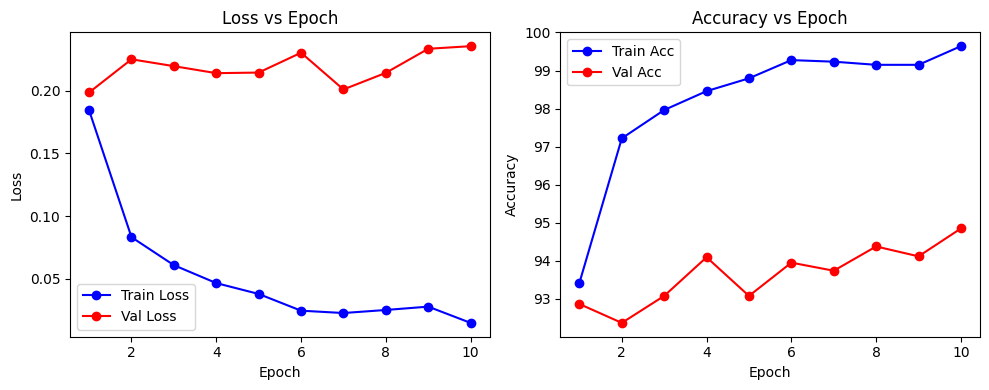

In [91]:
epochs = range(1, EPOCHS+1)
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, val_losses,   'ro-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accs, 'bo-', label='Train Acc')
plt.plot(epochs, val_accs,   'ro-', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()

plt.tight_layout()
plt.savefig("training_curves.png", dpi=300)
plt.show()

In [92]:
torch.save(model, "resnet_cnn_model.pt")